In [21]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [330]:
def gen_mfcc_fn(fn, mfcc_window_size, mfcc_stride_size):
    
    X, sample_rate = librosa.load(fn, sr=None, mono=True)
            
    if sample_rate != 44100:
        return
                
    mfcc = librosa.feature.mfcc(X, sample_rate, 
                            n_fft=int(mfcc_window_size * sample_rate), 
                            hop_length=int(mfcc_stride_size * sample_rate))
    return mfcc.T

In [331]:
def generate_mfccs_for_gmm(parent_dir, 
                     sub_dirs, 
                     file_ext='*.wav', 
                     mfcc_window_size=0.02, mfcc_stride_size=0.01):
    
    mfccs = np.empty((0, 20))
    
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            
            mfcc = gen_mfcc_fn(fn, mfcc_window_size, mfcc_stride_size)
            if mfcc is None:
                continue
            
            mfccs = np.vstack([mfccs, mfcc])
    
    return mfccs

In [332]:
parent_dir = './UrbanSound8K/audio/'
tr_sub_dirs = ['fold%d'% d for d in range(1, 2)]

mfccs_for_gmm = generate_mfccs_for_gmm(parent_dir, tr_sub_dirs)
print(mfccs_for_gmm.shape)

(132147, 20)


In [32]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=64, verbose=10)
gmm.fit(mfccs_for_gmm)

Initialization 0
  Iteration 0	 time lapse 11.38020s	 ll change inf
  Iteration 10	 time lapse 36.51747s	 ll change 0.08164
  Iteration 20	 time lapse 35.59874s	 ll change 0.00713
  Iteration 30	 time lapse 38.07266s	 ll change 0.00539
  Iteration 40	 time lapse 38.19159s	 ll change 0.00250
  Iteration 50	 time lapse 35.89631s	 ll change 0.00089
Initialization converged: True	 time lapse 195.65732s	 ll -69.63772


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=64, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=10,
        verbose_interval=10, warm_start=False, weights_init=None)

In [70]:
print(mfccs_for_gmm[0].shape)
y = gmm.predict_proba(mfccs_for_gmm[:1])
print(y[0].shape)

(20,)
(64,)


In [1216]:
import pickle

pickle.dump(gmm, open('gaussian_mixture_model.pkl', 'wb'))

In [1217]:
gmm_bak = pickle.load(open('gaussian_mixture_model.pkl', 'rb'))

In [1218]:
gmm_bak

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=64, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=10,
        verbose_interval=10, warm_start=False, weights_init=None)

In [417]:
sound_class_table = {
    'air_conditioner' : 0,
    'car_horn' : 1,
    'children_playing' : 2,
    'dog_bark' : 3,
    'drilling' : 4,
    'engine_idling' : 5,
    'gun_shot' : 6,
    'jackhammer' : 7,
    'siren' : 8,
    'street_music' : 9
}

def segment_window(audio_len, segment_len, segment_stride):
    
    start = 0
    while start < audio_len:
        yield start, start + segment_len
        start += segment_stride
        
def generate_labels(fn, target_class):

    return 1 if int(fn.split('-')[-3]) == sound_class_table[target_class] \
                else -1

def generate_F_features(parent_dir, 
                             sub_dirs,
                             num_segment_needed,
                             target_class,
                             file_ext='*.wav', 
                             mfcc_window_size=0.02, 
                             mfcc_stride_size=0.01):
    
    F_features, labels = np.empty((0, 64)), np.array([])

    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            
            X, sample_rate = librosa.load(fn, sr=None, mono=True)
            if sample_rate != 44100:
                continue

            segment_len = int(sample_rate * 0.1)
            segment_stride = int(sample_rate * 0.05)
            
#             file_F_features = np.empty((0, 64))
            for start, end in segment_window(X.size, segment_len, segment_stride):
                segment_mfccs = librosa.feature.mfcc(X[start:end], sample_rate, 
                                    n_fft=int(mfcc_window_size * sample_rate), 
                                    hop_length=int(mfcc_stride_size * sample_rate))
                
                segment_F_features = np.sum(gmm.predict_proba(segment_mfccs.T), axis=0) \
                                        / (segment_mfccs.shape[1])
                    
                F_features = np.vstack([F_features, segment_F_features])
            
                labels = np.append(labels, generate_labels(fn, target_class))
                
                if labels.shape[0] >= num_segment_needed:
                    return np.array(F_features), np.array(labels, dtype=np.int)
#             F_features.append(file_F_features)
        
    print("Finished!")
    return np.array(F_features), np.array(labels, dtype=np.int)

In [882]:
def extract_test_fn_labels(fn, duration, target_class):

    label_file_path = fn.replace('wav', 'txt')

    with open(label_file_path) as fd:
        lines = fd.readlines()
        time_sections_with_label = list(map(lambda x: (float(x[0]), float(x[1]), x[2]), map(lambda x : x.split(), lines)))
    
    time_intervals = np.arange(0.0, duration, 0.05)
    labels = np.zeros((time_intervals.shape[0]), dtype=np.int)

    for idx, t in enumerate(time_intervals):
        
        labels[idx] = -1
        
        for time_section in time_sections_with_label:
            if t < time_section[0] or t > time_section[1]:
                continue
            
            if time_section[2] == target_class:
                labels[idx] = 1
                break

    return labels

def gen_test_fn_features(fn):
    
    X, sample_rate = librosa.load(fn, sr=None, mono=True)
    if sample_rate != 44100:
        return X, sample_rate, None
    
    segment_len = int(sample_rate * 0.1)
    segment_stride = int(sample_rate * 0.05)
    
    print(fn)
    file_F_features = np.empty((0, 64))
    for start, end in segment_window(X.size, segment_len, segment_stride):
        segment_mfccs = librosa.feature.mfcc(X[start:end], sample_rate, 
                            n_fft=int(0.02 * sample_rate), 
                            hop_length=int(0.01 * sample_rate))

        segment_F_features = np.sum(gmm.predict_proba(segment_mfccs.T), axis=0) \
                                / (segment_mfccs.shape[1])

        file_F_features = np.vstack([file_F_features, segment_F_features])
    
    return X, sample_rate, file_F_features
                
def gen_testing_data_for_svm(target_class, parent_dir = '.', 
                             sub_dirs = ['soundscapes_5_events_sub'],
                             file_ext='*.wav'):
    
    F_features, labels = [], []
    
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            
            X, sample_rate, file_F_features = gen_test_fn_features(fn)
            if file_F_features is None:
                continue
            
            fn_labels = extract_test_fn_labels(fn, X.size/sample_rate, target_class)
            labels.append(fn_labels)    
            F_features.append(file_F_features)
        
    print("Finished!")
    return F_features, labels

# def gen_testing_data_for_svm(target_class, parent_dir = '.', 
#                              sub_dirs = ['soundscapes_5_events_sub'],
#                              file_ext='*.wav'):
    
#     F_features, labels = [], []
#     fns = []
#     for label, sub_dir in enumerate(sub_dirs):
#         for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            
#             X, sample_rate, file_F_features = gen_test_fn_features(fn)
#             if file_F_features is None:
#                 continue
#             fns.append(fn)
#             print(fn)
# #             fn_labels = extract_test_fn_labels(fn, X.size/sample_rate, target_class)
# #             labels.append(fn_labels)    
#             F_features.append(file_F_features)
        
#     print("Finished!")
#     return F_features, fns

In [578]:
def gen_training_data_for_svm(num_target_class_segment, target_class):
    
    parent_dir = './UrbanSound8K/ByClass'
    
    F_features_target_class, labels_target_class = generate_F_features(parent_dir,
                                                                       [target_class],
                                                                       num_target_class_segment,
                                                                       target_class)
    
    F_features_non_target_class = np.empty((0, 64))
    labels_non_target_class = np.array([])

    for k, _ in sound_class_table.items():
        if k == target_class:
            continue

        tmp_F_features, tmp_labels = generate_F_features(parent_dir, 
                            [k],
                            int(num_target_class_segment/9),
                            target_class)
    
        F_features_non_target_class = np.vstack([F_features_non_target_class, tmp_F_features])
        labels_non_target_class = np.append(labels_non_target_class, tmp_labels)
    
    return np.vstack([F_features_non_target_class, F_features_target_class]), \
            np.append(labels_non_target_class, labels_target_class)

In [1195]:
X_all, y_all = gen_training_data_for_svm(1800, target_class='air_conditioner')

In [1196]:
print(X_all.shape)
print(y_all.shape)

(3600, 64)
(3600,)


In [1197]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, stratify=y_all, train_size=0.85)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3060, 64)
(3060,)
(540, 64)
(540,)


In [1207]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', C=100, gamma=10, probability=True)
clf.fit(X_train, y_train)

print("Training set score: {:.3f}".format(clf.score(X_train, y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test, y_test)))

Training set score: 0.910
Test set score: 0.894


In [1219]:
from sklearn.metrics import confusion_matrix
print(clf.classes_)
confusion_matrix(y_test, clf.predict(X_test))

[-1.  1.]


array([[217,  53],
       [  4, 266]])

In [1209]:
import pickle
pickle.dump(clf, open('./sound_detectors/air_conditioner_detector.pkl', 'wb'))

In [1211]:
F_features_test, labels_test = gen_testing_data_for_svm(target_class='air_conditioner', 
                                                        parent_dir='./soundscapes', 
                                                        sub_dirs=['air_conditioner'])

./soundscapes/air_conditioner/soundscape_56.wav
./soundscapes/air_conditioner/soundscape_42.wav
./soundscapes/air_conditioner/soundscape_95.wav
./soundscapes/air_conditioner/soundscape_81.wav
./soundscapes/air_conditioner/soundscape_80.wav
./soundscapes/air_conditioner/soundscape_94.wav
./soundscapes/air_conditioner/soundscape_43.wav
./soundscapes/air_conditioner/soundscape_57.wav
./soundscapes/air_conditioner/soundscape_41.wav
./soundscapes/air_conditioner/soundscape_55.wav
./soundscapes/air_conditioner/soundscape_69.wav
./soundscapes/air_conditioner/soundscape_82.wav
./soundscapes/air_conditioner/soundscape_96.wav
./soundscapes/air_conditioner/soundscape_97.wav
./soundscapes/air_conditioner/soundscape_83.wav
./soundscapes/air_conditioner/soundscape_68.wav
./soundscapes/air_conditioner/soundscape_54.wav
./soundscapes/air_conditioner/soundscape_40.wav
./soundscapes/air_conditioner/soundscape_78.wav
./soundscapes/air_conditioner/soundscape_44.wav
./soundscapes/air_conditioner/soundscape

In [ ]:
np.savetxt("./sound_detector_test_data/siren_test_features.csv", np.array(F_features_test), delimiter=",")
np.savetxt("./sound_detector_test_data/siren_test_labels.csv", np.array(labels_test), delimiter=",")

In [1212]:
print(np.array(F_features_test).shape)
print(np.array(labels_test).shape)

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

recall_scores = []
precision_scores = []
f1_scores = []
accuracy_scores = []

for x, y in zip(F_features_test, labels_test):
    preds = clf.predict(x)
    recall_scores.append(recall_score(y, preds))
    precision_scores.append(precision_score(y, preds))
    f1_scores.append(f1_score(y, preds))
    accuracy_scores.append(accuracy_score(y, preds))

(100,)
(100,)


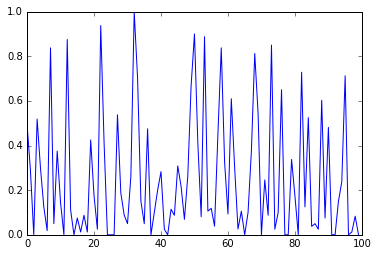

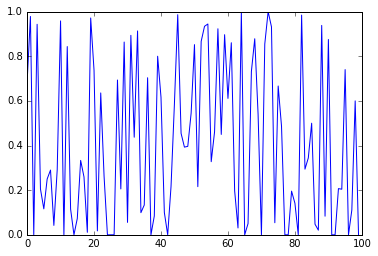

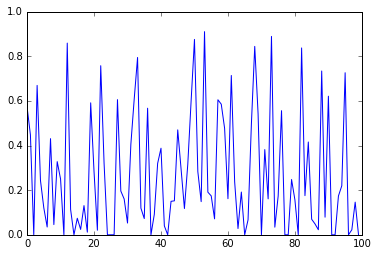

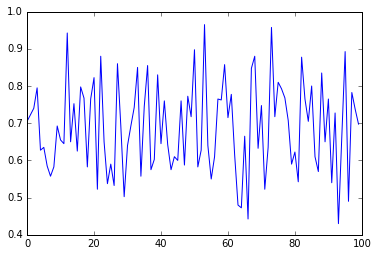

In [1213]:
plt.plot(recall_scores)
plt.show()
plt.plot(precision_scores)
plt.show()
plt.plot(f1_scores)
plt.show()
plt.plot(accuracy_scores)
plt.show()

In [1214]:
# 0.696400072903
# 0.697101319222
# 0.669004671073
# 0.8357

print(np.mean(recall_scores))
print(np.mean(precision_scores))
print(np.mean(f1_scores))
print(np.mean(accuracy_scores))

0.255838121178
0.412409033263
0.273474194091
0.689105798005


100
675
100
53
[(0.915, './UrbanSound8K/ByClass/air_conditioner/75743-0-0-6.wav'), (0.9075, './UrbanSound8K/ByClass/air_conditioner/189982-0-0-4.wav'), (0.97, './UrbanSound8K/ByClass/air_conditioner/146845-0-0-21.wav'), (0.9525, './UrbanSound8K/ByClass/air_conditioner/146709-0-0-65.wav'), (0.9325, './UrbanSound8K/ByClass/air_conditioner/134717-0-0-26.wav'), (0.9925, './UrbanSound8K/ByClass/air_conditioner/147926-0-0-44.wav'), (0.905, './UrbanSound8K/ByClass/air_conditioner/75743-0-0-11.wav'), (0.925, './UrbanSound8K/ByClass/air_conditioner/189989-0-0-0.wav'), (0.945, './UrbanSound8K/ByClass/air_conditioner/55018-0-0-106.wav'), (0.9325, './UrbanSound8K/ByClass/air_conditioner/74507-0-0-13.wav'), (0.925, './UrbanSound8K/ByClass/air_conditioner/83502-0-0-10.wav'), (0.9125, './UrbanSound8K/ByClass/air_conditioner/13230-0-0-10.wav'), (0.9675, './UrbanSound8K/ByClass/air_conditioner/189989-0-0-1.wav'), (0.915, './UrbanSound8K/ByClass/air_conditioner/75743-0-0-10.wav'), (0.965, './UrbanSound8

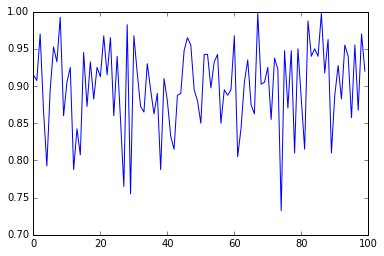

In [1078]:
print(len(F_features_test))
print(len(fns))
preds = list(map(lambda d: clf.predict(d), F_features_test))
precisions = list(map(lambda d: d.tolist().count(1)/len(d), preds))
print(len(precisions))
plt.plot(precisions)

fs = list(filter(lambda p: p[0]>=.9, zip(precisions, fns)))
print(len(fs))
print(fs)

In [ ]:
import os

for f in fs:
#     os.system('cp %s ./hownoisy/data/ByClass/air_conditioner' % (f[1]))